# Imports

In [1]:
# base
import numpy as np
import pkg_resources
from sklearn.impute import SimpleImputer
from pandas_plink import read_plink

# viz
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs

# feems
from feems.utils import prepare_graph_inputs
from feems import SpatialGraph, Viz
from feems.cross_validation import run_cv

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

# Data

Prepare the wolf genotype data:

In [2]:
data_path = pkg_resources.resource_filename("feems", "data/")

# read the genotype data and mean impute missing data
(bim, fam, G) = read_plink("{}/wolvesadmix".format(data_path))
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
genotypes = imp.fit_transform((np.array(G)).T)

# setup graph
coord = np.loadtxt("{}/wolvesadmix.coord".format(data_path))  # sample coordinates
outer = np.loadtxt("{}/wolvesadmix.outer".format(data_path))  # outer coordinates
grid_path = "{}/grid_100.shp".format(data_path)  # path to discrete global grid

# graph input files
outer, edges, grid, _ = prepare_graph_inputs(coord=coord, 
                                             ggrid=grid_path,
                                             translated=True, 
                                             buffer=0,
                                             outer=outer)

# construct spatial graph object
sp_graph = SpatialGraph(genotypes, coord, grid, edges, scale_snps=True)

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 22.09it/s]


# Run cross-validation

Next we perform leave-one-out cross-valiation over a grid of $\lambda$ values. In our CV we hold out indivudal observed nodes on the graph, predict allele frequencies at the held-out node under our fitted model, and use the $\ell_2$ distance between the fitted and predicted allele frequencies as our CV metric to select the best model: 

In [3]:
%%time
# define grids
# reverse the order of lambdas and alphas for warmstart
lamb_grid = np.geomspace(1e-6, 1e2, 20)[::-1]

# run cross-validation
cv_err = run_cv(sp_graph, lamb_grid, n_folds=sp_graph.n_observed_nodes, factr=1e8)

# average over folds
mean_cv_err = np.mean(cv_err, axis=0)

# argmin of cv error
lamb_cv = float(lamb_grid[np.argmin(mean_cv_err)])


 fold= 0
iteration lambda=20/20 alpha=1/1
 fold= 1
iteration lambda=20/20 alpha=1/1
 fold= 2
iteration lambda=20/20 alpha=1/1
 fold= 3
iteration lambda=20/20 alpha=1/1
 fold= 4
iteration lambda=20/20 alpha=1/1
 fold= 5
iteration lambda=20/20 alpha=1/1
 fold= 6
iteration lambda=20/20 alpha=1/1
 fold= 7
iteration lambda=20/20 alpha=1/1
 fold= 8
iteration lambda=20/20 alpha=1/1
 fold= 9
iteration lambda=20/20 alpha=1/1
 fold= 10
iteration lambda=20/20 alpha=1/1
 fold= 11
iteration lambda=20/20 alpha=1/1
 fold= 12
iteration lambda=20/20 alpha=1/1
 fold= 13
iteration lambda=20/20 alpha=1/1
 fold= 14
iteration lambda=20/20 alpha=1/1
 fold= 15
iteration lambda=20/20 alpha=1/1
 fold= 16
iteration lambda=20/20 alpha=1/1
 fold= 17
iteration lambda=20/20 alpha=1/1
 fold= 18
iteration lambda=20/20 alpha=1/1
 fold= 19
iteration lambda=20/20 alpha=1/1
 fold= 20
iteration lambda=20/20 alpha=1/1
 fold= 21
iteration lambda=20/20 alpha=1/1
 fold= 22
iteration lambda=20/20 alpha=1/1
 fold= 23
iteration 

Plot CV error:

2.06913808111479


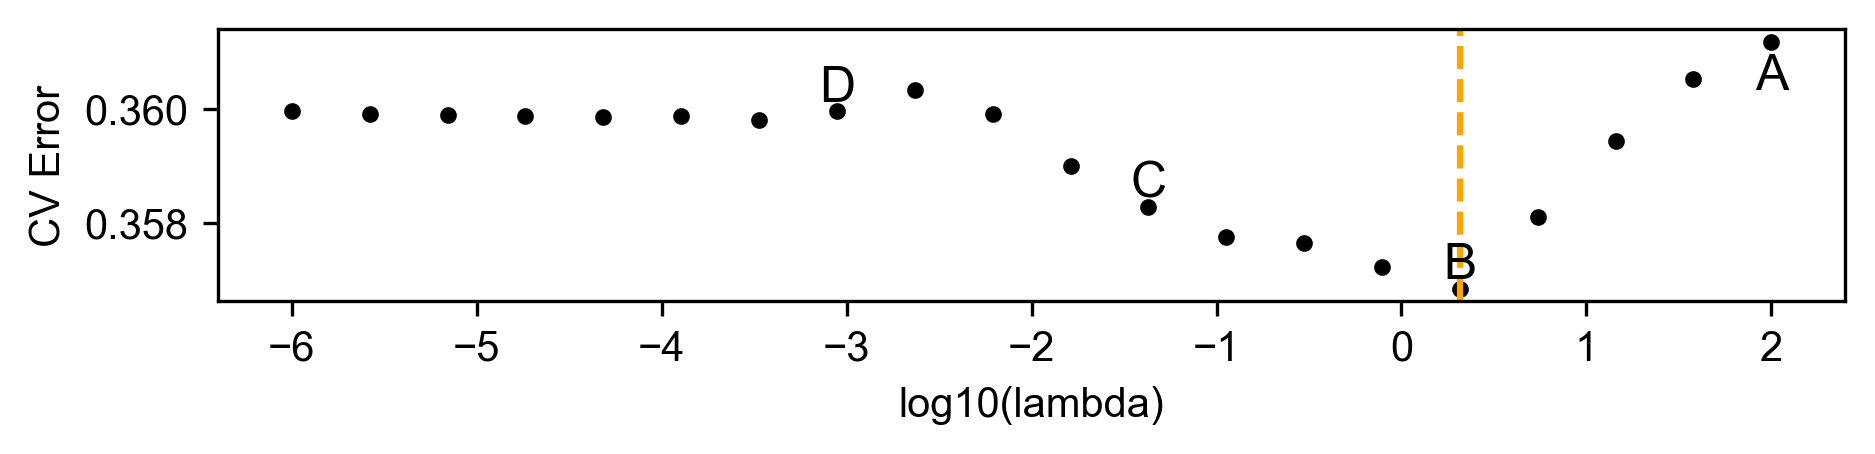

In [43]:
fig, ax = plt.subplots(dpi=300, figsize=(7, 1.2))
ax.plot(np.log10(lamb_grid), mean_cv_err, ".", color="black");
ax.set_xlabel("log10(lambda)");
ax.set_ylabel("CV Error");
ax.axvline(np.log10(lamb_cv), color = "orange", linestyle="dashed")
ax.text(np.log10(lamb_grid[0]), mean_cv_err[0, 0] - .0002, "A", fontdict={"fontsize": 12, "horizontalalignment": "center", "verticalalignment": "top"})
ax.text(np.log10(lamb_cv), mean_cv_err[np.argmin(mean_cv_err), 0], "B", fontdict={"fontsize": 12, "horizontalalignment": "center", "verticalalignment": "bottom"})
ax.text(np.log10(lamb_grid[8]), mean_cv_err[8, 0], "C", fontdict={"fontsize": 12, "horizontalalignment": "center", "verticalalignment": "bottom"})
ax.text(np.log10(lamb_grid[12]), mean_cv_err[12, 0], "D", fontdict={"fontsize": 12, "horizontalalignment": "center", "verticalalignment": "bottom"})

print(lamb_cv)

In [44]:
fig.savefig(
    "../output/figures/supp-figure-x-cv-curve.pdf", bbox_inches="tight", pad_inches=.1
)

Lets take a look at a summary of CV:

constant-w/variance fit, converged in 132 iterations, train_loss=2795677.6543430
lambda=100.0000000, alpha=0.8354260, converged in 67 iterations, train_loss=2790840.4427914
constant-w/variance fit, converged in 132 iterations, train_loss=2795677.6543430
lambda=2.0691381, alpha=0.8354260, converged in 86 iterations, train_loss=2767305.7147592
constant-w/variance fit, converged in 132 iterations, train_loss=2795677.6543430
lambda=0.0428133, alpha=0.8354260, converged in 279 iterations, train_loss=2749770.9999993
constant-w/variance fit, converged in 132 iterations, train_loss=2795677.6543430
lambda=0.0008859, alpha=0.8354260, converged in 1083 iterations, train_loss=2744775.6875427
CPU times: user 40.2 s, sys: 34.9 ms, total: 40.3 s
Wall time: 40.5 s


Text(0.2, 0.9, 'lambda=0.00089\ncv error=0.35995')

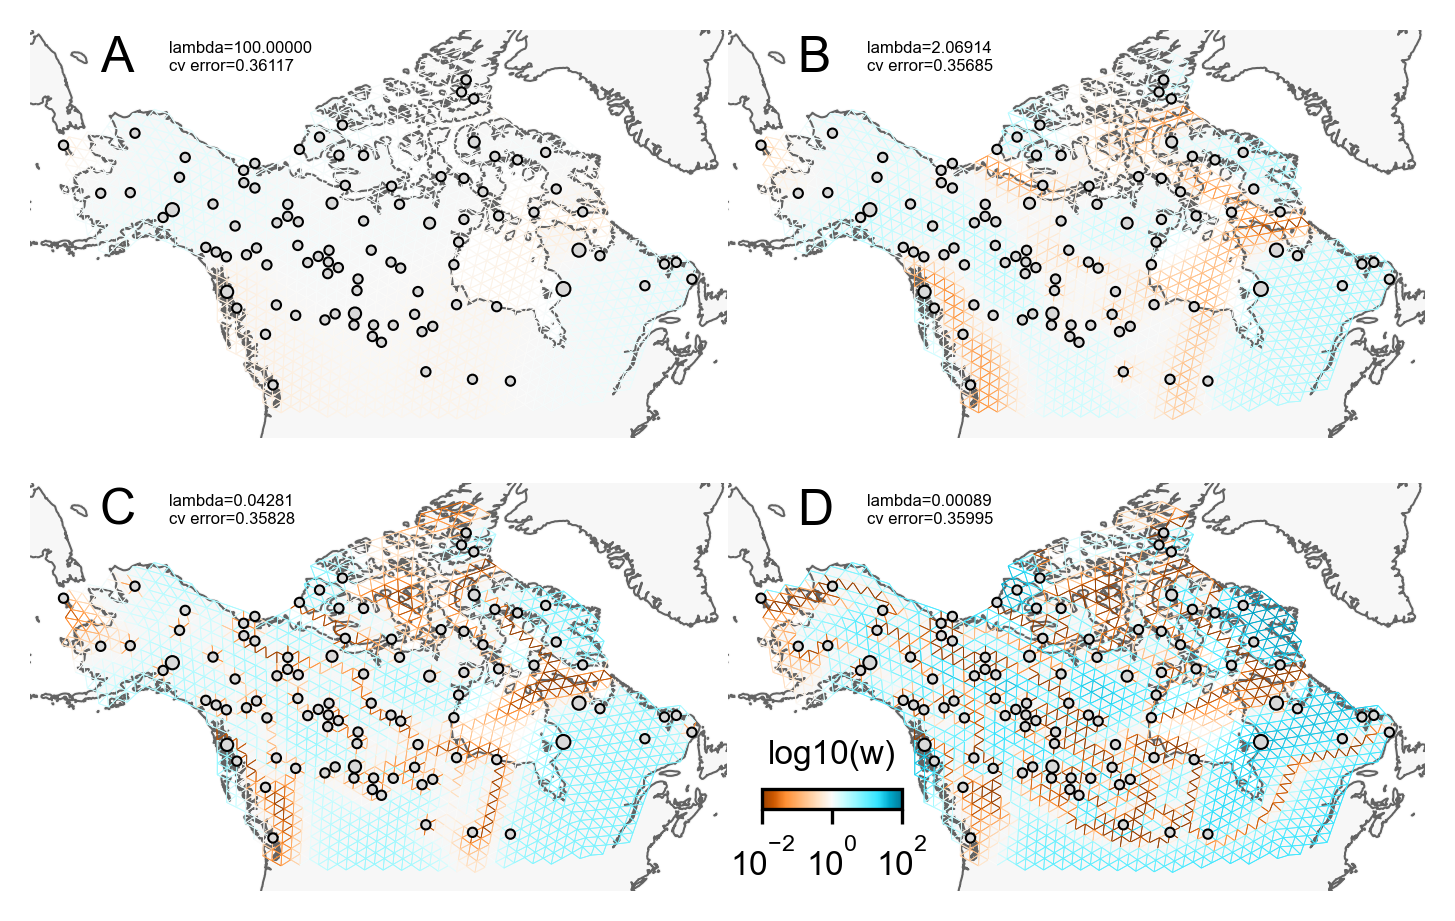

In [40]:
%%time
# figure params
projection = ccrs.EquidistantConic(central_longitude=-108.842926, central_latitude=66.037547)
title_loc = "left"
title_pad = "-10"
title_fontsize = 12
edge_width = .2
edge_alpha = 1
edge_zorder = 3
obs_node_size = 5
obs_node_linewidth = .4
cbar_font_size = 8
cbar_ticklabelsize = 8
cbar_orientation = "horizontal"

# figure setup
fig = plt.figure(dpi=300)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig, wspace=0.0, hspace=0.0)

# axis 00 
ax_00 = fig.add_subplot(spec[0, 0], projection=projection)
ax_00.set_title("A", x=0.1, loc=title_loc, pad=title_pad, fontdict={"fontsize": title_fontsize})
sp_graph.fit(float(lamb_grid[0]))
v = Viz(ax_00, sp_graph, projection=projection, edge_width=edge_width, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=obs_node_size, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
ax_00.text(.2, .9, "lambda={:.5f}\ncv error={:.5f}".format(lamb_grid[0], mean_cv_err[0, 0]), 
           fontdict={"fontsize": 4}, transform = ax_00.transAxes)

# axis 01
ax_01 = fig.add_subplot(spec[0, 1], projection=projection)
ax_01.set_title("B", x=0.1, loc=title_loc, pad=title_pad, fontdict={"fontsize": title_fontsize})
sp_graph.fit(float(lamb_cv))
v = Viz(ax_01, sp_graph, projection=projection, edge_width=edge_width, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=obs_node_size, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
ax_01.text(.2, .9, "lambda={:.5f}\ncv error={:.5f}".format(lamb_cv, mean_cv_err[np.argmin(mean_cv_err), 0]), 
           fontdict={"fontsize": 4}, transform = ax_01.transAxes)

# axis 10
ax_10 = fig.add_subplot(spec[1, 0], projection=projection)
ax_10.set_title("C", x=0.1, loc=title_loc, pad=title_pad, fontdict={"fontsize": title_fontsize})
sp_graph.fit(float(lamb_grid[8]))
v = Viz(ax_10, sp_graph, projection=projection, edge_width=edge_width, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20,
        obs_node_size=obs_node_size, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
ax_10.text(.2, .9, "lambda={:.5f}\ncv error={:.5f}".format(lamb_grid[8], mean_cv_err[8, 0]), 
           fontdict={"fontsize": 4}, transform = ax_10.transAxes)


# axis 11
ax_11 = fig.add_subplot(spec[1, 1], projection=projection)
ax_11.set_title("D", x=0.1, loc=title_loc, pad=title_pad, fontdict={"fontsize": title_fontsize})
sp_graph.fit(float(lamb_grid[12]))
v = Viz(ax_11, sp_graph, projection=projection, edge_width=edge_width, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=obs_node_size, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False)
v.cbar_font_size = cbar_font_size
v.cbar_orientation = cbar_orientation
v.cbar_ticklabelsize = cbar_ticklabelsize
v.draw_edge_colorbar()
ax_11.text(.2, .9, "lambda={:.5f}\ncv error={:.5f}".format(lamb_grid[12], mean_cv_err[12, 0]), 
           fontdict={"fontsize": 4}, transform = ax_11.transAxes)

Save output figure:

In [41]:
fig.savefig(
    "../output/figures/figure-3-wolves-reg-path.pdf", bbox_inches="tight", pad_inches=.1
)

Lets make a zoom in figure using the fit that has the lowest error on the CV curve:

constant-w/variance fit, converged in 132 iterations, train_loss=2795677.6543430
lambda=2.0691400, alpha=0.8354260, converged in 85 iterations, train_loss=2767305.7342289
CPU times: user 4.04 s, sys: 15 ms, total: 4.06 s
Wall time: 4.08 s


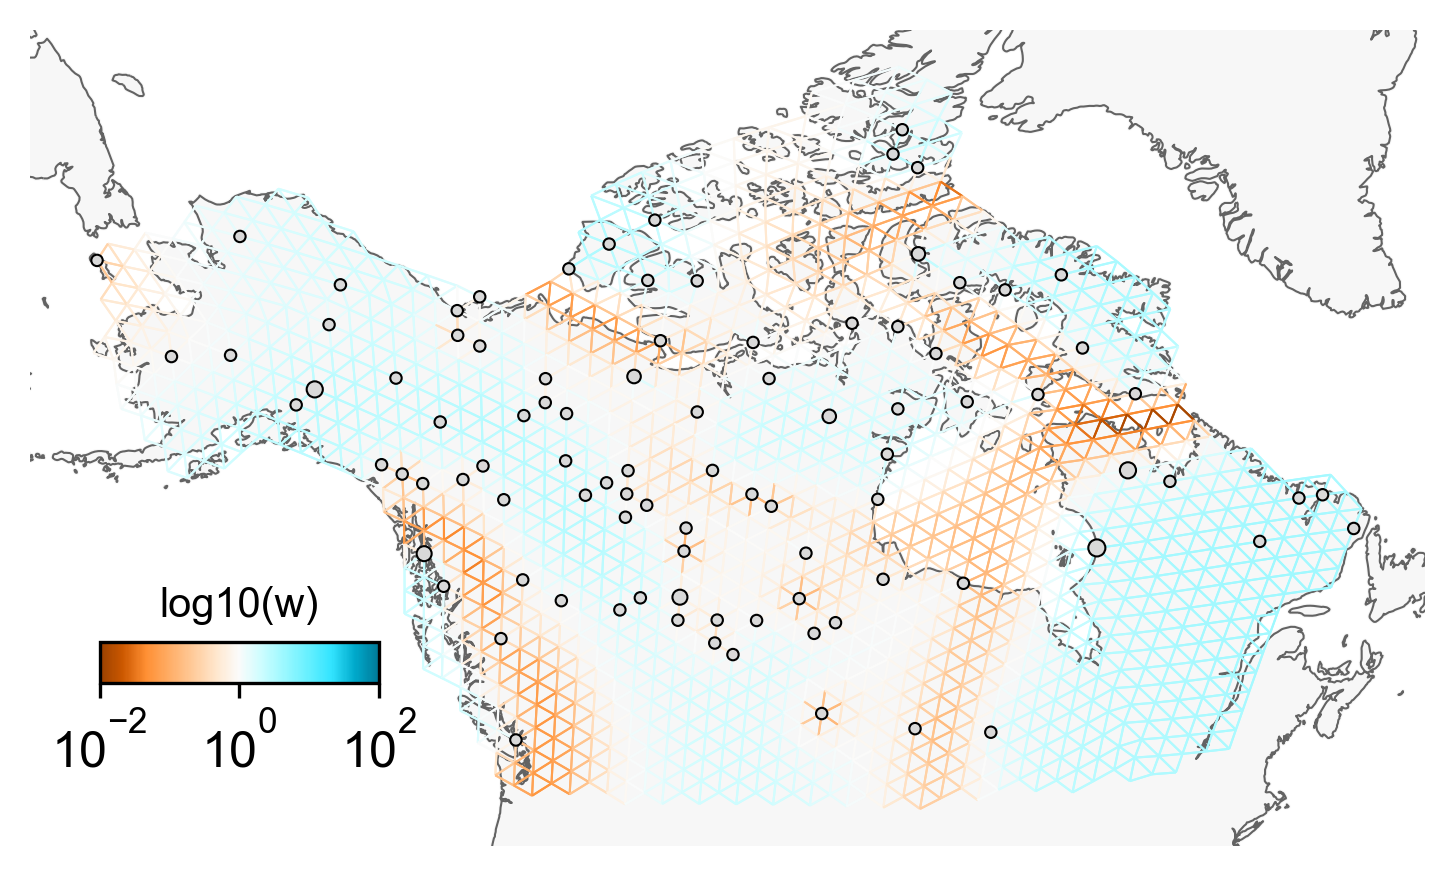

In [4]:
# re-fit
sp_graph.fit(lamb_cv)

# plot
projection = ccrs.EquidistantConic(central_longitude=-108.842926, central_latitude=66.037547)
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
v.draw_edge_colorbar()

Save output figure:

In [ ]:
fig.savefig(
    "../output/figures/figure-4-wolves-cv-opt.pdf", bbox_inches="tight", pad_inches=.1
)